In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import hdf5plugin
import h5py

from scipy.optimize import curve_fit
from scipy.signal import correlate
from scipy.stats import sigmaclip
import time

In [2]:
f = h5py.File('/datag/pipeline/AGBT19B_999_117/blc40_blp00/blc40_guppi_58817_05391_TIC245947683_0015.gpuspec.0000.h5')
f_center = 11249.7563360
width_bins = 1024

In [3]:
def to_idx(freq):
    return int((freq - f['data'].attrs['fch1']) / f['data'].attrs['foff'])

idx_low = to_idx(f_center) - width_bins//2
idx_hi = to_idx(f_center) + width_bins//2

In [4]:
idx_hi, f['data'].shape[-1]

(612010, 67108864)

In [5]:
snippet = f['data'][:, 0, idx_low:idx_hi]

In [6]:
def gaussian(x, a, mu, sigma, c):
    """Gaussian function with noise floor for fitting"""
    return a * np.exp(-(x - mu)**2 / (2 * sigma**2)) + c

def method1_gaussian_fit(spectrum):
    """
    Method 1: Fit a Gaussian with noise floor and return FWHM
    """
    x = np.arange(len(spectrum))
    
    # Initial guess for parameters
    max_idx = np.argmax(spectrum)
    a_guess = spectrum[max_idx]
    mu_guess = max_idx
    sigma_guess = len(spectrum) / 8  # rough guess
    
    # Estimate noise floor from edges
    edge_size = len(spectrum) // 5
    noise_samples = np.concatenate([spectrum[:edge_size], spectrum[-edge_size:]])
    c_guess = np.median(noise_samples)
    
    # Adjust amplitude guess to account for noise floor
    a_guess = a_guess - c_guess
    
    try:
        popt, _ = curve_fit(gaussian, x, spectrum, 
                           p0=[a_guess, mu_guess, sigma_guess, c_guess],
                           maxfev=1000)
        sigma_fit = abs(popt[2])
        fwhm = 2.355 * sigma_fit  # FWHM = 2.355 * sigma for Gaussian
        return fwhm
    except:
        return np.nan

def method2_boxcar_correlation(spectrum):
    """
    Method 2: Boxcar correlation to estimate width
    
    This method works by correlating the spectrum with boxcar functions 
    of different widths and finding the width that gives maximum correlation.
    The idea is that a boxcar of the correct width will best match the 
    signal shape.
    """
    max_width = len(spectrum) // 2
    correlations = []
    widths = range(1, max_width, 2)  # odd widths only
    
    for width in widths:
        # Create boxcar filter
        boxcar = np.zeros(len(spectrum))
        center = len(spectrum) // 2
        start = center - width // 2
        end = center + width // 2 + 1
        boxcar[start:end] = 1
        
        # Normalize boxcar
        boxcar = boxcar / np.sum(boxcar)
        
        # Compute correlation
        corr = np.corrcoef(spectrum, boxcar)[0, 1]
        if not np.isnan(corr):
            correlations.append(corr)
        else:
            correlations.append(0)
    
    if correlations:
        best_width_idx = np.argmax(correlations)
        return widths[best_width_idx]
    else:
        return np.nan

def method3_threshold_based(spectrum):
    """
    Method 3: Threshold-based width estimation
    
    Find noise floor, calculate middle point between noise and peak,
    then find width where signal drops below this threshold.
    """
    noise_floor = np.median(spectrum)
    
    # Find peak
    peak_value = np.max(spectrum)
    peak_idx = np.argmax(spectrum)
    
    # Calculate threshold (middle point between noise and peak)
    threshold = (noise_floor + peak_value) / 2
    
    # Find points above threshold around the peak
    above_threshold = spectrum > threshold
    
    if not np.any(above_threshold):
        return np.nan
    
    # Find the first and last indices above threshold
    above_indices = np.where(above_threshold)[0]
    width = abs(above_indices[-1] - above_indices[0]) + 1
    
    return width

def method4_sigma_clipped_threshold(spectrum):
    """
    Method 4: Sigma-clipped threshold-based width estimation
    
    Same as threshold method but uses iterative sigma clipping to estimate
    the noise floor instead of using edge samples.
    """
    # Use sigma clipping to estimate noise floor from entire spectrum
    # This iteratively removes outliers (signals) to get a clean noise estimate
    clipped_data, lower_bound, upper_bound = sigmaclip(spectrum, low=2.0, high=2.0)
    noise_floor = np.median(clipped_data)
    
    # Find peak
    peak_value = np.max(spectrum)
    peak_idx = np.argmax(spectrum)
    
    # Calculate threshold (middle point between noise and peak)
    threshold = (noise_floor + peak_value) / 2
    
    # Find points above threshold around the peak
    above_threshold = spectrum > threshold
    
    if not np.any(above_threshold):
        return np.nan
    
    # Find the first and last indices above threshold
    above_indices = np.where(above_threshold)[0]
    width = abs(above_indices[-1] - above_indices[0]) + 1
    
    return width

In [7]:
# Apply all methods to each time slice
print(f"Processing {snippet.shape[0]} time slices...")

# Storage for results
results = {
    'gaussian_widths': [],
    'boxcar_widths': [],
    'threshold_widths': [],
    'sigma_clipped_widths': []
}

# Timing measurements
timing_results = {
    'gaussian_time': 0,
    'boxcar_time': 0,
    'threshold_time': 0,
    'sigma_clipped_time': 0
}

# Process each time slice
for i in range(snippet.shape[0]):
    spectrum = snippet[i, :]
    
    # Method 1: Gaussian fitting
    start_time = time.perf_counter()
    width_gaussian = method1_gaussian_fit(spectrum)
    timing_results['gaussian_time'] += time.perf_counter() - start_time
    results['gaussian_widths'].append(width_gaussian)
    
    # Method 2: Boxcar correlation
    start_time = time.perf_counter()
    width_boxcar = method2_boxcar_correlation(spectrum)
    timing_results['boxcar_time'] += time.perf_counter() - start_time
    results['boxcar_widths'].append(width_boxcar)
    
    # Method 3: Threshold-based
    start_time = time.perf_counter()
    width_threshold = method3_threshold_based(spectrum)
    timing_results['threshold_time'] += time.perf_counter() - start_time
    results['threshold_widths'].append(width_threshold)
    
    # Method 4: Sigma-clipped threshold-based
    start_time = time.perf_counter()
    width_sigma_clipped = method4_sigma_clipped_threshold(spectrum)
    timing_results['sigma_clipped_time'] += time.perf_counter() - start_time
    results['sigma_clipped_widths'].append(width_sigma_clipped)

# Convert to numpy arrays for easier handling
for key in results:
    results[key] = np.array(results[key])

print("Processing complete!")
print(f"\nTiming results (total time for {snippet.shape[0]} spectra):")
print(f"Gaussian fitting: {timing_results['gaussian_time']:.4f} seconds")
print(f"Boxcar correlation: {timing_results['boxcar_time']:.4f} seconds")
print(f"Threshold-based: {timing_results['threshold_time']:.4f} seconds")
print(f"Sigma-clipped threshold: {timing_results['sigma_clipped_time']:.4f} seconds")

print(f"\nAverage time per spectrum:")
print(f"Gaussian fitting: {timing_results['gaussian_time']/snippet.shape[0]*1000:.2f} ms")
print(f"Boxcar correlation: {timing_results['boxcar_time']/snippet.shape[0]*1000:.2f} ms")
print(f"Threshold-based: {timing_results['threshold_time']/snippet.shape[0]*1000:.2f} ms")
print(f"Sigma-clipped threshold: {timing_results['sigma_clipped_time']/snippet.shape[0]*1000:.2f} ms")

Processing 16 time slices...
Processing complete!

Timing results (total time for 16 spectra):
Gaussian fitting: 0.0252 seconds
Boxcar correlation: 0.2181 seconds
Threshold-based: 0.0011 seconds
Sigma-clipped threshold: 0.0079 seconds

Average time per spectrum:
Gaussian fitting: 1.58 ms
Boxcar correlation: 13.63 ms
Threshold-based: 0.07 ms
Sigma-clipped threshold: 0.49 ms
Processing complete!

Timing results (total time for 16 spectra):
Gaussian fitting: 0.0252 seconds
Boxcar correlation: 0.2181 seconds
Threshold-based: 0.0011 seconds
Sigma-clipped threshold: 0.0079 seconds

Average time per spectrum:
Gaussian fitting: 1.58 ms
Boxcar correlation: 13.63 ms
Threshold-based: 0.07 ms
Sigma-clipped threshold: 0.49 ms


In [8]:
# Display statistics of the results
print("\nWidth estimation statistics:")
print("="*50)

for method_name, widths in results.items():
    valid_widths = widths[~np.isnan(widths)]
    if len(valid_widths) > 0:
        print(f"\n{method_name.replace('_', ' ').title()}:")
        print(f"  Valid estimates: {len(valid_widths)}/{len(widths)} ({100*len(valid_widths)/len(widths):.1f}%)")
        print(f"  Mean width: {np.mean(valid_widths):.2f} bins")
        print(f"  Std width: {np.std(valid_widths):.2f} bins")
        print(f"  Min width: {np.min(valid_widths):.2f} bins")
        print(f"  Max width: {np.max(valid_widths):.2f} bins")
    else:
        print(f"\n{method_name.replace('_', ' ').title()}:")
        print("  No valid estimates found")


Width estimation statistics:

Gaussian Widths:
  Valid estimates: 16/16 (100.0%)
  Mean width: 17.50 bins
  Std width: 1.91 bins
  Min width: 14.64 bins
  Max width: 21.98 bins

Boxcar Widths:
  Valid estimates: 16/16 (100.0%)
  Mean width: 25.88 bins
  Std width: 5.61 bins
  Min width: 17.00 bins
  Max width: 43.00 bins

Threshold Widths:
  Valid estimates: 16/16 (100.0%)
  Mean width: 15.94 bins
  Std width: 2.38 bins
  Min width: 14.00 bins
  Max width: 24.00 bins

Sigma Clipped Widths:
  Valid estimates: 16/16 (100.0%)
  Mean width: 15.94 bins
  Std width: 2.38 bins
  Min width: 14.00 bins
  Max width: 24.00 bins


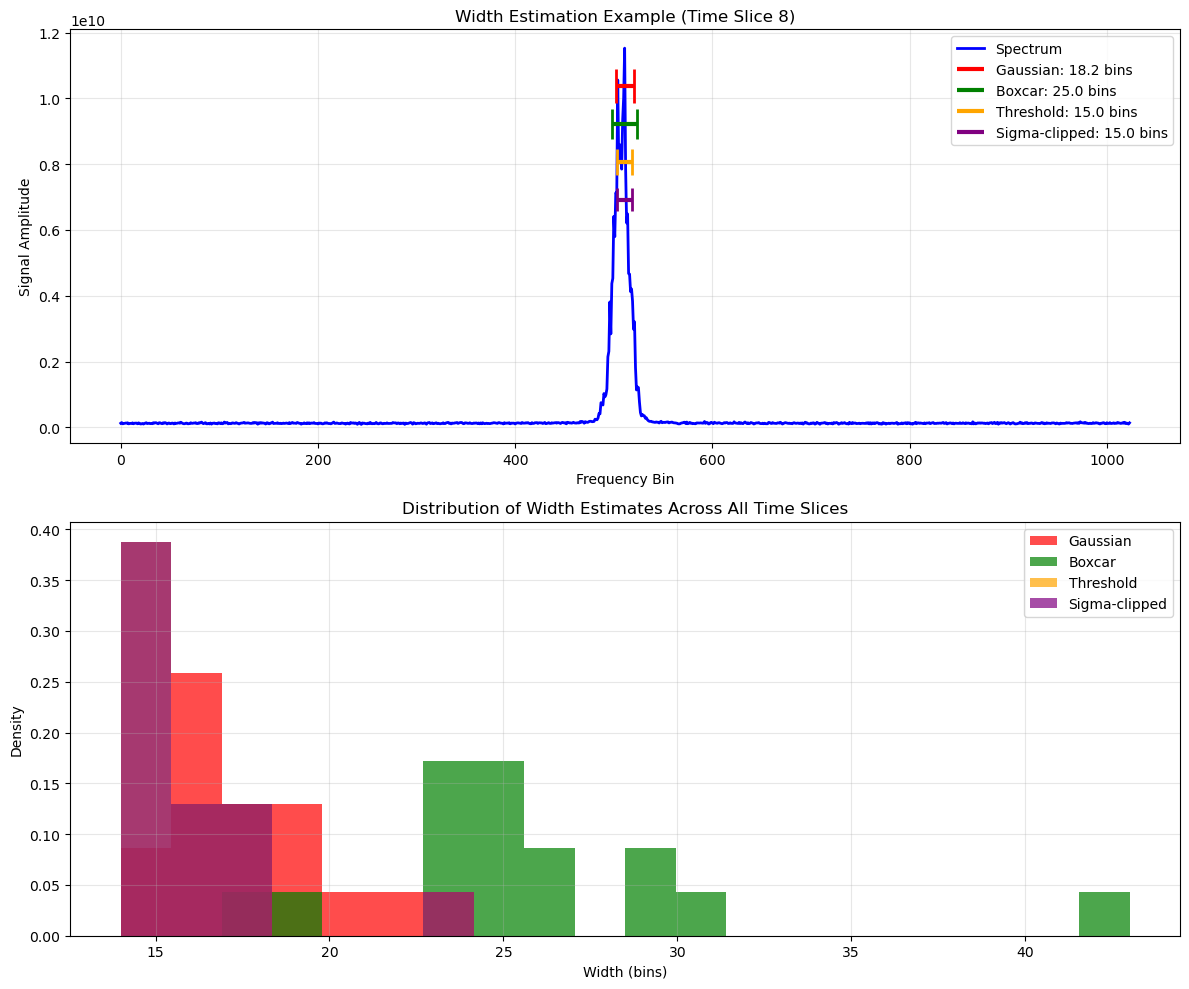


Example spectrum (time slice 8) width estimates:
Gaussian: 18.19 bins
Boxcar: 25.00 bins
Threshold: 15.00 bins
Sigma-clipped: 15.00 bins


In [9]:
# Visualize results on an example spectrum
# Choose a time slice with valid estimates from all methods
valid_indices = []
for i in range(len(results['gaussian_widths'])):
    if (not np.isnan(results['gaussian_widths'][i]) and 
        not np.isnan(results['boxcar_widths'][i]) and 
        not np.isnan(results['threshold_widths'][i]) and
        not np.isnan(results['sigma_clipped_widths'][i])):
        valid_indices.append(i)

if valid_indices:
    # Use the middle valid spectrum
    example_idx = valid_indices[len(valid_indices)//2]
    example_spectrum = snippet[example_idx, :]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot 1: Spectrum with width indicators
    x_axis = np.arange(len(example_spectrum))
    ax1.plot(x_axis, example_spectrum, 'b-', linewidth=2, label='Spectrum')
    
    # Find peak for centering width indicators
    peak_idx = np.argmax(example_spectrum)
    peak_value = example_spectrum[peak_idx]
    
    # Add width indicators
    colors = ['red', 'green', 'orange', 'purple']
    methods = ['Gaussian', 'Boxcar', 'Threshold', 'Sigma-clipped']
    widths_to_plot = [results['gaussian_widths'][example_idx], 
                      results['boxcar_widths'][example_idx], 
                      results['threshold_widths'][example_idx],
                      results['sigma_clipped_widths'][example_idx]]
    
    for i, (method, width, color) in enumerate(zip(methods, widths_to_plot, colors)):
        if not np.isnan(width):
            # Draw horizontal line at peak indicating width
            y_offset = peak_value * (0.9 - i*0.1)  # Stagger the lines
            left_edge = peak_idx - width/2
            right_edge = peak_idx + width/2
            ax1.hlines(y_offset, left_edge, right_edge, colors=color, linewidth=3, 
                      label=f'{method}: {width:.1f} bins')
            # Add vertical markers at edges
            ax1.vlines([left_edge, right_edge], y_offset*0.95, y_offset*1.05, colors=color, linewidth=2)
    
    ax1.set_xlabel('Frequency Bin')
    ax1.set_ylabel('Signal Amplitude')
    ax1.set_title(f'Width Estimation Example (Time Slice {example_idx})')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Distribution of width estimates across all time slices
    # Calculate common bins based on the range of all valid width estimates
    all_valid_widths = []
    for method_widths in [results['gaussian_widths'], results['boxcar_widths'], 
                          results['threshold_widths'], results['sigma_clipped_widths']]:
        valid_widths = method_widths[~np.isnan(method_widths)]
        if len(valid_widths) > 0:
            all_valid_widths.extend(valid_widths)
    
    if all_valid_widths:
        # Create common bins spanning the full range of all methods
        min_width = np.min(all_valid_widths)
        max_width = np.max(all_valid_widths)
        common_bins = np.linspace(min_width, max_width, 21)  # 21 edges = 20 bins
    else:
        common_bins = 20  # Fallback to automatic binning
    
    ax2.hist(results['gaussian_widths'][~np.isnan(results['gaussian_widths'])], 
             bins=common_bins, alpha=0.7, label='Gaussian', color='red', density=True)
    ax2.hist(results['boxcar_widths'][~np.isnan(results['boxcar_widths'])], 
             bins=common_bins, alpha=0.7, label='Boxcar', color='green', density=True)
    ax2.hist(results['threshold_widths'][~np.isnan(results['threshold_widths'])], 
             bins=common_bins, alpha=0.7, label='Threshold', color='orange', density=True)
    ax2.hist(results['sigma_clipped_widths'][~np.isnan(results['sigma_clipped_widths'])], 
             bins=common_bins, alpha=0.7, label='Sigma-clipped', color='purple', density=True)
    
    ax2.set_xlabel('Width (bins)')
    ax2.set_ylabel('Density')
    ax2.set_title('Distribution of Width Estimates Across All Time Slices')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nExample spectrum (time slice {example_idx}) width estimates:")
    print(f"Gaussian: {results['gaussian_widths'][example_idx]:.2f} bins")
    print(f"Boxcar: {results['boxcar_widths'][example_idx]:.2f} bins") 
    print(f"Threshold: {results['threshold_widths'][example_idx]:.2f} bins")
    print(f"Sigma-clipped: {results['sigma_clipped_widths'][example_idx]:.2f} bins")
    
else:
    print("No time slices found with valid estimates from all three methods for visualization.")

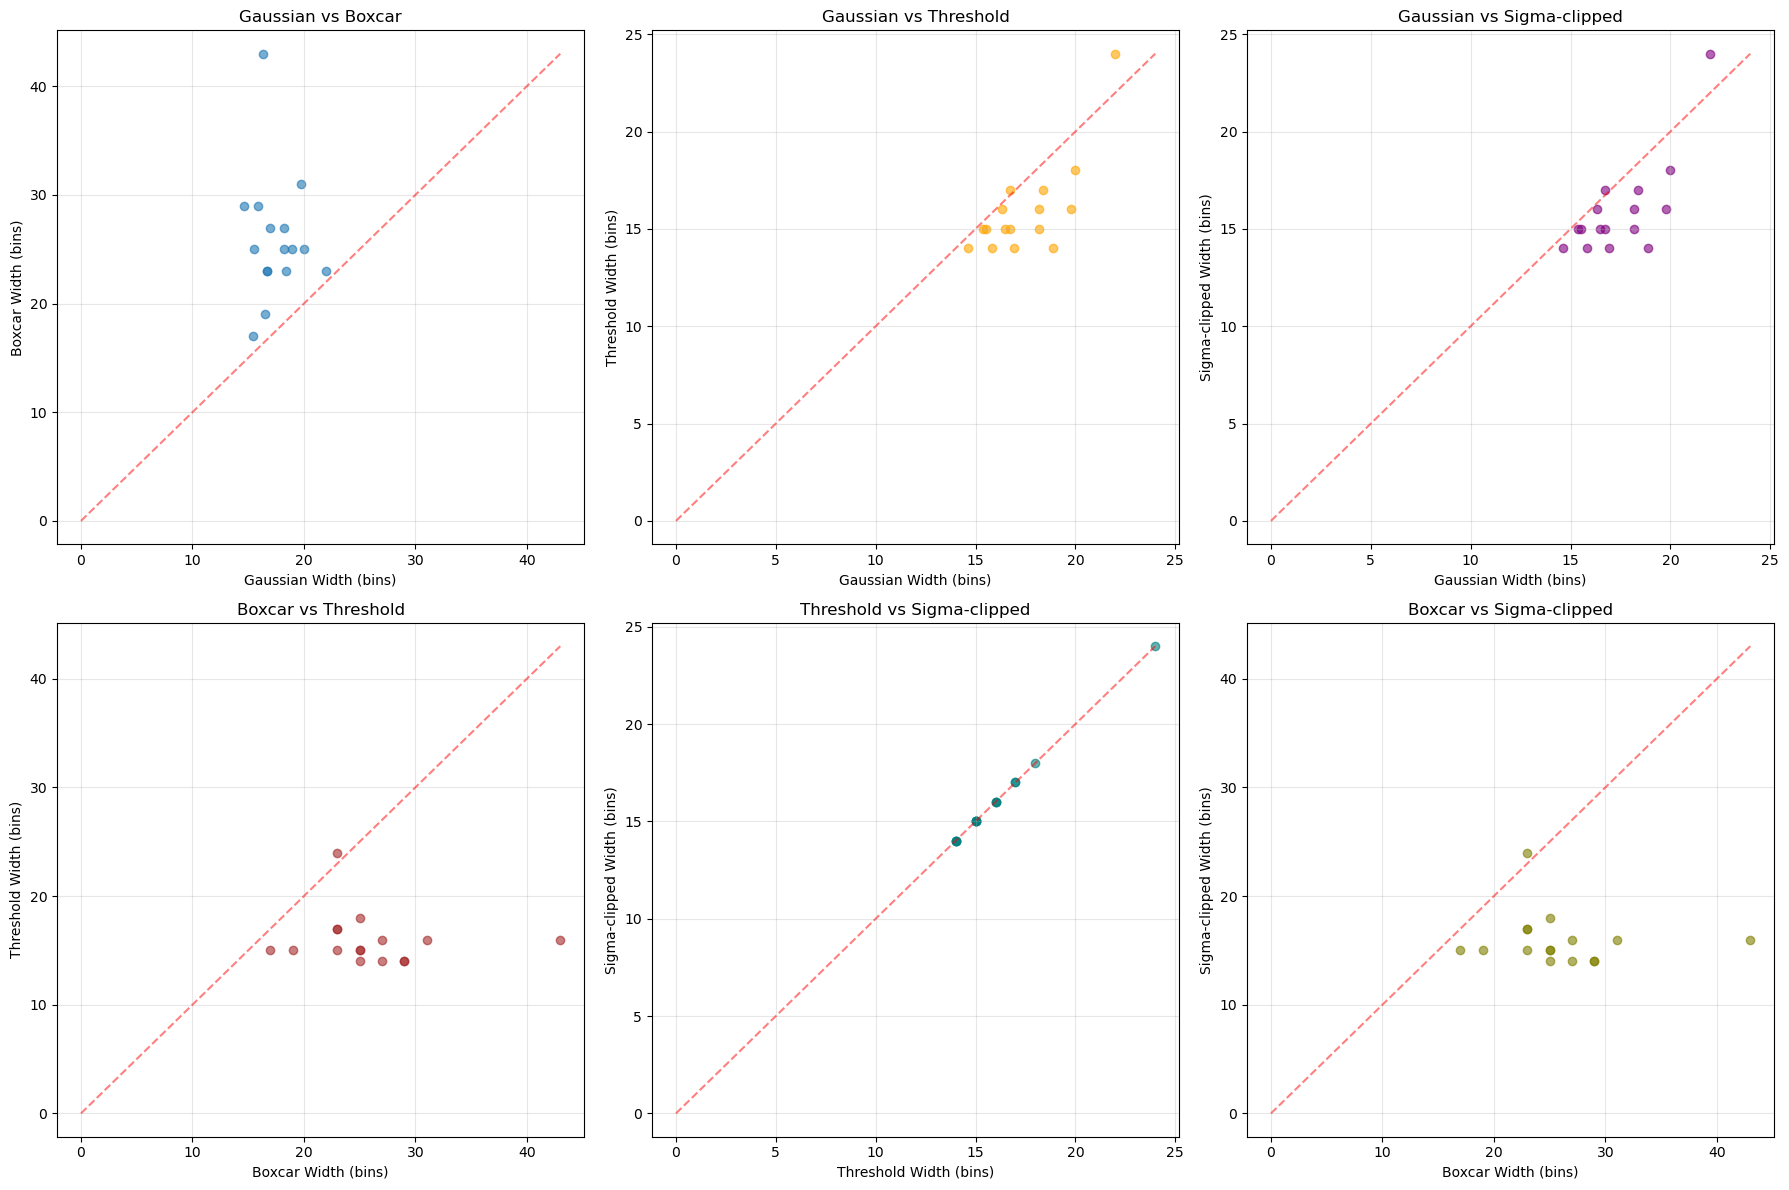

Method Correlations:
Gaussian vs Boxcar: -0.057
Gaussian vs Threshold: 0.734
Gaussian vs Sigma-clipped: 0.734
Boxcar vs Threshold: -0.108
Threshold vs Sigma-clipped: 1.000
Boxcar vs Sigma-clipped: -0.108


In [10]:
# Compare methods directly - now with 4 methods
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Get valid data for comparisons
gaussian_valid = results['gaussian_widths'][~np.isnan(results['gaussian_widths'])]
boxcar_valid = results['boxcar_widths'][~np.isnan(results['boxcar_widths'])]
threshold_valid = results['threshold_widths'][~np.isnan(results['threshold_widths'])]
sigma_clipped_valid = results['sigma_clipped_widths'][~np.isnan(results['sigma_clipped_widths'])]

# Find common valid indices for direct comparison
common_valid = ~(np.isnan(results['gaussian_widths']) | 
                 np.isnan(results['boxcar_widths']) | 
                 np.isnan(results['threshold_widths']) |
                 np.isnan(results['sigma_clipped_widths']))

if np.sum(common_valid) > 0:
    gauss_common = results['gaussian_widths'][common_valid]
    boxcar_common = results['boxcar_widths'][common_valid]
    threshold_common = results['threshold_widths'][common_valid]
    sigma_clipped_common = results['sigma_clipped_widths'][common_valid]
    
    # Gaussian vs Boxcar
    axes[0].scatter(gauss_common, boxcar_common, alpha=0.6)
    axes[0].set_xlabel('Gaussian Width (bins)')
    axes[0].set_ylabel('Boxcar Width (bins)')
    axes[0].set_title('Gaussian vs Boxcar')
    axes[0].plot([0, max(np.max(gauss_common), np.max(boxcar_common))], 
                 [0, max(np.max(gauss_common), np.max(boxcar_common))], 'r--', alpha=0.5)
    axes[0].grid(True, alpha=0.3)
    
    # Gaussian vs Threshold
    axes[1].scatter(gauss_common, threshold_common, alpha=0.6, color='orange')
    axes[1].set_xlabel('Gaussian Width (bins)')
    axes[1].set_ylabel('Threshold Width (bins)')
    axes[1].set_title('Gaussian vs Threshold')
    axes[1].plot([0, max(np.max(gauss_common), np.max(threshold_common))], 
                 [0, max(np.max(gauss_common), np.max(threshold_common))], 'r--', alpha=0.5)
    axes[1].grid(True, alpha=0.3)
    
    # Gaussian vs Sigma-clipped
    axes[2].scatter(gauss_common, sigma_clipped_common, alpha=0.6, color='purple')
    axes[2].set_xlabel('Gaussian Width (bins)')
    axes[2].set_ylabel('Sigma-clipped Width (bins)')
    axes[2].set_title('Gaussian vs Sigma-clipped')
    axes[2].plot([0, max(np.max(gauss_common), np.max(sigma_clipped_common))], 
                 [0, max(np.max(gauss_common), np.max(sigma_clipped_common))], 'r--', alpha=0.5)
    axes[2].grid(True, alpha=0.3)
    
    # Boxcar vs Threshold
    axes[3].scatter(boxcar_common, threshold_common, alpha=0.6, color='brown')
    axes[3].set_xlabel('Boxcar Width (bins)')
    axes[3].set_ylabel('Threshold Width (bins)')
    axes[3].set_title('Boxcar vs Threshold')
    axes[3].plot([0, max(np.max(boxcar_common), np.max(threshold_common))], 
                 [0, max(np.max(boxcar_common), np.max(threshold_common))], 'r--', alpha=0.5)
    axes[3].grid(True, alpha=0.3)
    
    # Threshold vs Sigma-clipped
    axes[4].scatter(threshold_common, sigma_clipped_common, alpha=0.6, color='teal')
    axes[4].set_xlabel('Threshold Width (bins)')
    axes[4].set_ylabel('Sigma-clipped Width (bins)')
    axes[4].set_title('Threshold vs Sigma-clipped')
    axes[4].plot([0, max(np.max(threshold_common), np.max(sigma_clipped_common))], 
                 [0, max(np.max(threshold_common), np.max(sigma_clipped_common))], 'r--', alpha=0.5)
    axes[4].grid(True, alpha=0.3)
    
    # Boxcar vs Sigma-clipped
    axes[5].scatter(boxcar_common, sigma_clipped_common, alpha=0.6, color='olive')
    axes[5].set_xlabel('Boxcar Width (bins)')
    axes[5].set_ylabel('Sigma-clipped Width (bins)')
    axes[5].set_title('Boxcar vs Sigma-clipped')
    axes[5].plot([0, max(np.max(boxcar_common), np.max(sigma_clipped_common))], 
                 [0, max(np.max(boxcar_common), np.max(sigma_clipped_common))], 'r--', alpha=0.5)
    axes[5].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate correlations
    corr_gauss_boxcar = np.corrcoef(gauss_common, boxcar_common)[0, 1]
    corr_gauss_threshold = np.corrcoef(gauss_common, threshold_common)[0, 1]
    corr_gauss_sigma = np.corrcoef(gauss_common, sigma_clipped_common)[0, 1]
    corr_boxcar_threshold = np.corrcoef(boxcar_common, threshold_common)[0, 1]
    corr_threshold_sigma = np.corrcoef(threshold_common, sigma_clipped_common)[0, 1]
    corr_boxcar_sigma = np.corrcoef(boxcar_common, sigma_clipped_common)[0, 1]
    
    print("Method Correlations:")
    print(f"Gaussian vs Boxcar: {corr_gauss_boxcar:.3f}")
    print(f"Gaussian vs Threshold: {corr_gauss_threshold:.3f}")
    print(f"Gaussian vs Sigma-clipped: {corr_gauss_sigma:.3f}")
    print(f"Boxcar vs Threshold: {corr_boxcar_threshold:.3f}")
    print(f"Threshold vs Sigma-clipped: {corr_threshold_sigma:.3f}")
    print(f"Boxcar vs Sigma-clipped: {corr_boxcar_sigma:.3f}")
    
else:
    print("No common valid estimates found for direct comparison.")

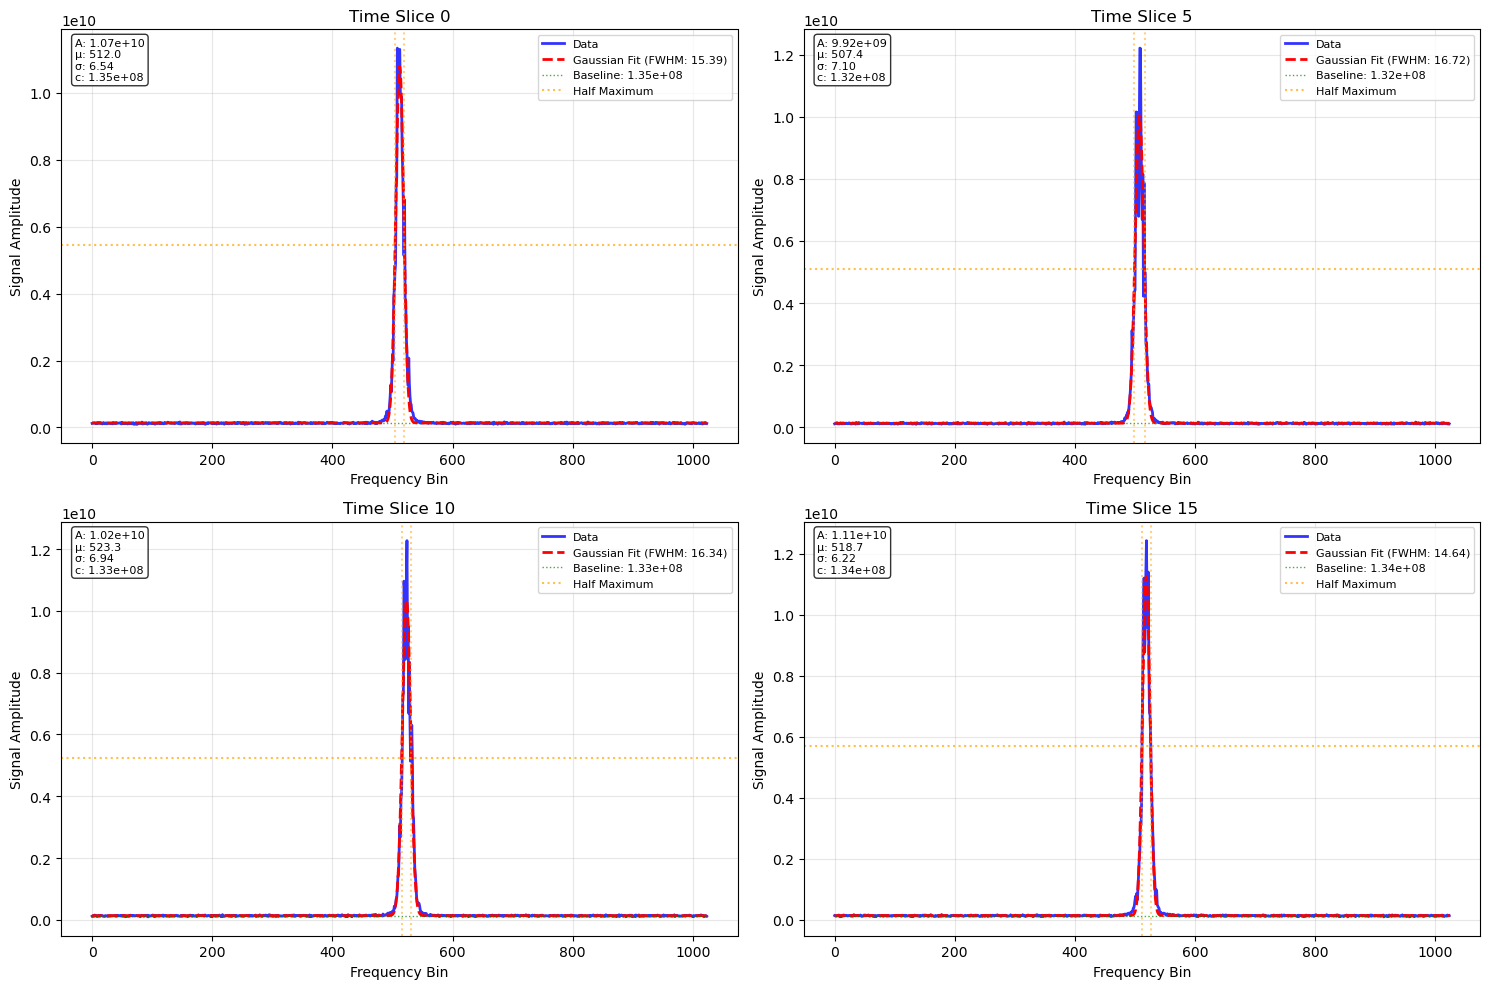

Gaussian fit examples showing:
- Blue solid line: Original data
- Red dashed line: Fitted Gaussian (signal + baseline)
- Green dotted line: Baseline level (constant offset)
- Orange dotted line: Half maximum level
- Orange vertical lines: FWHM boundaries


In [11]:
# Show Gaussian fits on example spectra
def gaussian_fit_with_params(spectrum):
    """Fit Gaussian and return both FWHM and fitted parameters"""
    x = np.arange(len(spectrum))
    
    # Initial guess for parameters
    max_idx = np.argmax(spectrum)
    a_guess = spectrum[max_idx]
    mu_guess = max_idx
    sigma_guess = len(spectrum) / 8
    
    # Estimate noise floor from edges
    edge_size = len(spectrum) // 5
    noise_samples = np.concatenate([spectrum[:edge_size], spectrum[-edge_size:]])
    c_guess = np.median(noise_samples)
    
    # Adjust amplitude guess to account for noise floor
    a_guess = a_guess - c_guess
    
    try:
        popt, pcov = curve_fit(gaussian, x, spectrum, 
                              p0=[a_guess, mu_guess, sigma_guess, c_guess],
                              maxfev=1000)
        sigma_fit = abs(popt[2])
        fwhm = 2.355 * sigma_fit
        return fwhm, popt, True
    except:
        return np.nan, None, False

# Select a few example spectra for visualization
n_examples = 4
example_indices = np.linspace(0, len(snippet)-1, n_examples, dtype=int)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, idx in enumerate(example_indices):
    spectrum = snippet[idx, :]
    x = np.arange(len(spectrum))
    
    # Fit Gaussian
    fwhm, params, success = gaussian_fit_with_params(spectrum)
    
    # Plot original spectrum
    axes[i].plot(x, spectrum, 'b-', linewidth=2, label='Data', alpha=0.8)
    
    if success and params is not None:
        # Plot fitted Gaussian
        fitted_curve = gaussian(x, *params)
        axes[i].plot(x, fitted_curve, 'r--', linewidth=2, 
                    label=f'Gaussian Fit (FWHM: {fwhm:.2f})')
        
        # Show individual components
        baseline = np.full_like(x, params[3])
        axes[i].plot(x, baseline, 'g:', linewidth=1, alpha=0.7, 
                    label=f'Baseline: {params[3]:.2e}')
        
        # Mark peak and FWHM boundaries
        peak_x = params[1]
        peak_y = gaussian(peak_x, *params)
        half_max = (peak_y + params[3]) / 2
        
        axes[i].axhline(half_max, color='orange', linestyle=':', alpha=0.7, 
                       label='Half Maximum')
        axes[i].axvline(peak_x - fwhm/2, color='orange', linestyle=':', alpha=0.5)
        axes[i].axvline(peak_x + fwhm/2, color='orange', linestyle=':', alpha=0.5)
        
        # Add fit parameters as text
        fit_text = f'A: {params[0]:.2e}\nμ: {params[1]:.1f}\nσ: {params[2]:.2f}\nc: {params[3]:.2e}'
        axes[i].text(0.02, 0.98, fit_text, transform=axes[i].transAxes, 
                    verticalalignment='top', fontsize=8, 
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    else:
        axes[i].text(0.5, 0.5, 'Fit Failed', transform=axes[i].transAxes,
                    ha='center', va='center', fontsize=12, color='red')
    
    axes[i].set_title(f'Time Slice {idx}')
    axes[i].set_xlabel('Frequency Bin')
    axes[i].set_ylabel('Signal Amplitude')
    axes[i].legend(fontsize=8)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Gaussian fit examples showing:")
print("- Blue solid line: Original data")
print("- Red dashed line: Fitted Gaussian (signal + baseline)")
print("- Green dotted line: Baseline level (constant offset)")
print("- Orange dotted line: Half maximum level")
print("- Orange vertical lines: FWHM boundaries")

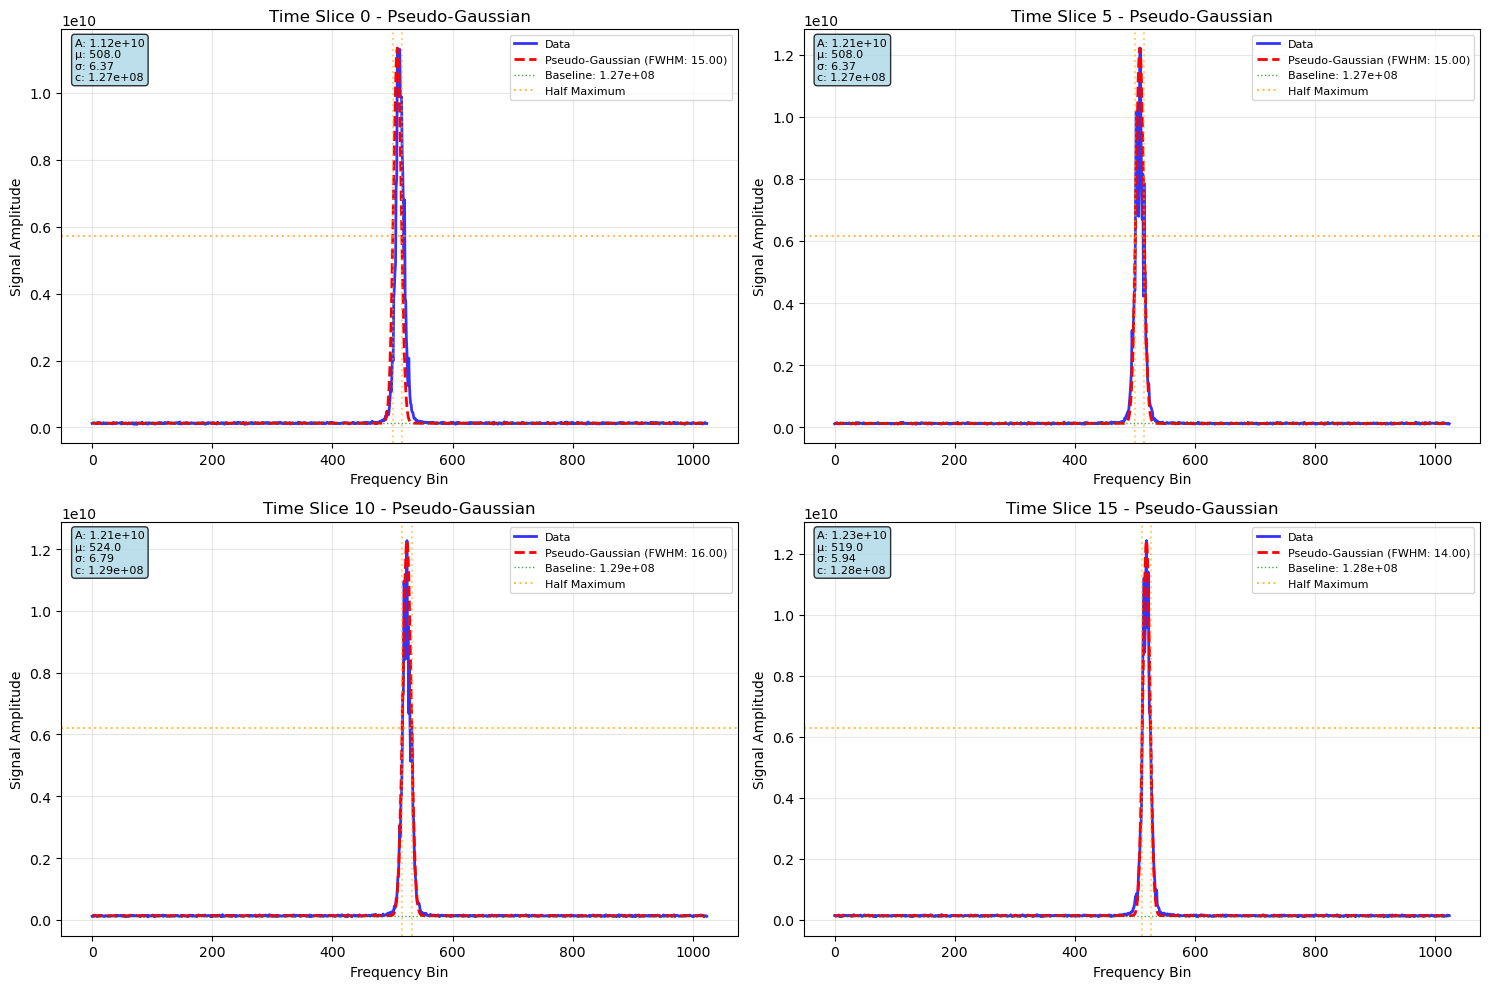

Pseudo-Gaussian parameter extraction showing:
- Blue solid line: Original data
- Red dashed line: Pseudo-Gaussian using extracted parameters
- Green dotted line: Baseline (median of edge samples)
- Orange dotted line: Half maximum level
- Orange vertical lines: FWHM boundaries from threshold method

Parameters derived from:
- Amplitude (A): max_value - noise_floor
- Mean (μ): location of maximum
- Sigma (σ): FWHM_threshold / 2.355
- Baseline (c): median of edge samples


In [12]:
# Show "pseudo-Gaussian" parameters using initial guesses + threshold method
def pseudo_gaussian_params(spectrum):
    """
    Get Gaussian-like parameters without fitting:
    - Amplitude: max - median (noise floor)
    - Mean: frequency at max power  
    - FWHM: from threshold method
    - Noise floor: median of edge samples
    - Convert FWHM to sigma: sigma = FWHM / 2.355
    """
    x = np.arange(len(spectrum))
    
    # Find peak
    max_idx = np.argmax(spectrum)
    peak_value = spectrum[max_idx]
    
    # Estimate noise floor from edges
    edge_size = len(spectrum) // 5
    noise_samples = np.concatenate([spectrum[:edge_size], spectrum[-edge_size:]])
    noise_floor = np.median(noise_samples)
    
    # Amplitude above noise floor
    amplitude = peak_value - noise_floor
    
    # Mean is just the peak location
    mean = max_idx
    
    # Get FWHM from threshold method
    fwhm_threshold = method3_threshold_based(spectrum)
    
    # Convert FWHM to sigma for Gaussian
    if not np.isnan(fwhm_threshold):
        sigma = fwhm_threshold / 2.355
        return amplitude, mean, sigma, noise_floor, fwhm_threshold, True
    else:
        return np.nan, np.nan, np.nan, np.nan, np.nan, False

# Use the same example indices as before
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, idx in enumerate(example_indices):
    spectrum = snippet[idx, :]
    x = np.arange(len(spectrum))
    
    # Get pseudo-Gaussian parameters
    amplitude, mean, sigma, noise_floor, fwhm, success = pseudo_gaussian_params(spectrum)
    
    # Plot original spectrum
    axes[i].plot(x, spectrum, 'b-', linewidth=2, label='Data', alpha=0.8)
    
    if success:
        # Create pseudo-Gaussian curve using the derived parameters
        pseudo_gaussian_curve = amplitude * np.exp(-(x - mean)**2 / (2 * sigma**2)) + noise_floor
        axes[i].plot(x, pseudo_gaussian_curve, 'r--', linewidth=2, 
                    label=f'Pseudo-Gaussian (FWHM: {fwhm:.2f})')
        
        # Show baseline
        baseline = np.full_like(x, noise_floor)
        axes[i].plot(x, baseline, 'g:', linewidth=1, alpha=0.7, 
                    label=f'Baseline: {noise_floor:.2e}')
        
        # Mark peak and FWHM boundaries
        peak_y = amplitude + noise_floor
        half_max = (peak_y + noise_floor) / 2
        
        axes[i].axhline(half_max, color='orange', linestyle=':', alpha=0.7, 
                       label='Half Maximum')
        axes[i].axvline(mean - fwhm/2, color='orange', linestyle=':', alpha=0.5)
        axes[i].axvline(mean + fwhm/2, color='orange', linestyle=':', alpha=0.5)
        
        # Add parameters as text
        param_text = f'A: {amplitude:.2e}\nμ: {mean:.1f}\nσ: {sigma:.2f}\nc: {noise_floor:.2e}'
        axes[i].text(0.02, 0.98, param_text, transform=axes[i].transAxes, 
                    verticalalignment='top', fontsize=8, 
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    else:
        axes[i].text(0.5, 0.5, 'Parameter extraction failed', transform=axes[i].transAxes,
                    ha='center', va='center', fontsize=12, color='red')
    
    axes[i].set_title(f'Time Slice {idx} - Pseudo-Gaussian')
    axes[i].set_xlabel('Frequency Bin')
    axes[i].set_ylabel('Signal Amplitude')
    axes[i].legend(fontsize=8)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Pseudo-Gaussian parameter extraction showing:")
print("- Blue solid line: Original data")
print("- Red dashed line: Pseudo-Gaussian using extracted parameters")
print("- Green dotted line: Baseline (median of edge samples)")
print("- Orange dotted line: Half maximum level")  
print("- Orange vertical lines: FWHM boundaries from threshold method")
print("\nParameters derived from:")
print("- Amplitude (A): max_value - noise_floor")
print("- Mean (μ): location of maximum")
print("- Sigma (σ): FWHM_threshold / 2.355")
print("- Baseline (c): median of edge samples")

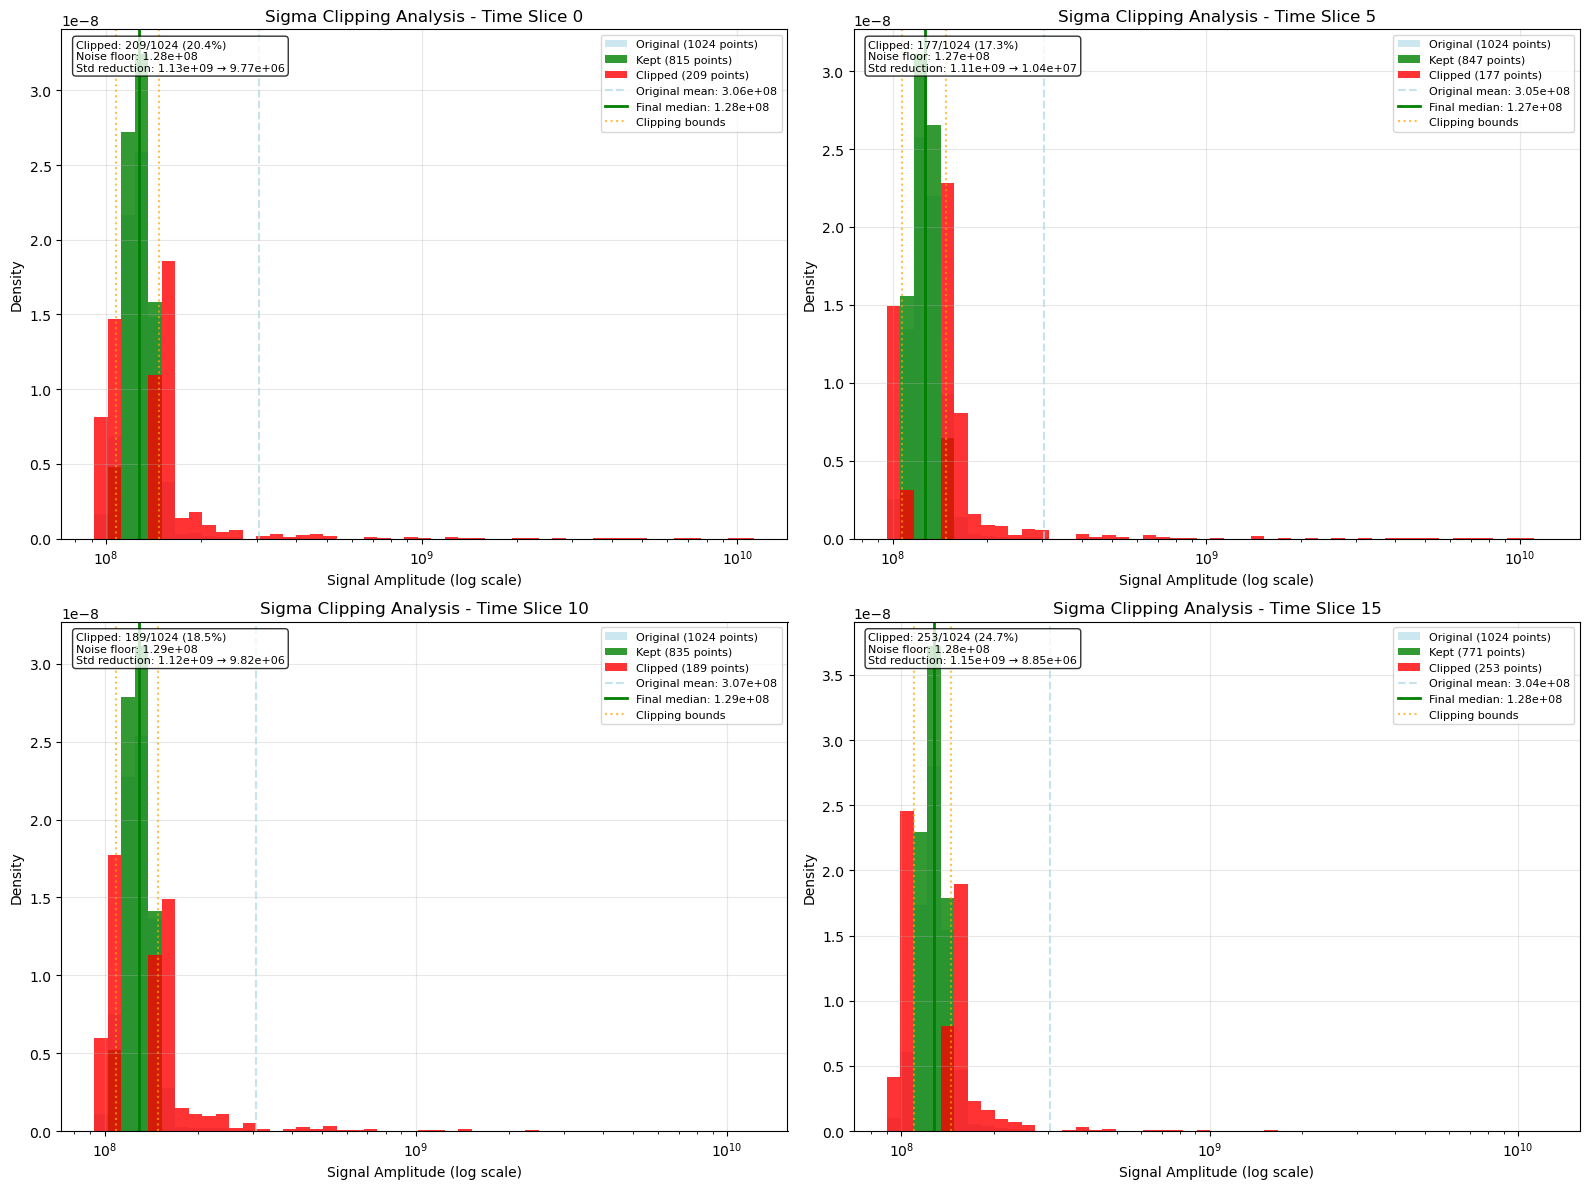

Sigma clipping analysis showing:
- Light blue: Original data distribution
- Green: Data points kept after sigma clipping
- Red: Data points removed by sigma clipping
- Dashed blue line: Original mean
- Solid green line: Final median (used as noise floor)
- Dotted orange lines: Clipping boundaries (mean ± 2σ)

Sigma clipping iteratively removes outliers to get a cleaner noise estimate.
The final median of the kept points becomes the noise floor estimate.


In [13]:
# Visualize what sigma clipping is doing to the data
def detailed_sigma_clipping_analysis(spectrum):
    """
    Perform sigma clipping step by step and return intermediate results
    """
    original_data = spectrum.copy()
    
    # Step 1: Initial statistics
    initial_mean = np.mean(original_data)
    initial_std = np.std(original_data)
    
    # Step 2: Apply sigma clipping
    clipped_data, lower_bound, upper_bound = sigmaclip(original_data, low=2.0, high=2.0)
    
    # Identify which points were clipped
    mask = (original_data >= lower_bound) & (original_data <= upper_bound)
    clipped_points = original_data[~mask]
    kept_points = original_data[mask]
    
    # Final statistics
    final_mean = np.mean(clipped_data)
    final_std = np.std(clipped_data)
    final_median = np.median(clipped_data)
    
    return {
        'original_data': original_data,
        'clipped_data': clipped_data,
        'kept_points': kept_points,
        'clipped_points': clipped_points,
        'mask': mask,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'initial_mean': initial_mean,
        'initial_std': initial_std,
        'final_mean': final_mean,
        'final_std': final_std,
        'final_median': final_median,
        'n_original': len(original_data),
        'n_kept': len(kept_points),
        'n_clipped': len(clipped_points)
    }

# Analyze sigma clipping on a few example spectra
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for i, idx in enumerate(example_indices):
    spectrum = snippet[idx, :]
    analysis = detailed_sigma_clipping_analysis(spectrum)
    
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    # Create log-spaced histogram bins that cover the full range
    data_range = [np.min(analysis['original_data']), np.max(analysis['original_data'])]
    # Ensure positive values for log scale (add small offset if needed)
    min_val = max(data_range[0], 1e-10)
    max_val = data_range[1]
    bins = np.logspace(np.log10(min_val), np.log10(max_val), 50)
    
    # Plot original data distribution
    ax.hist(analysis['original_data'], bins=bins, alpha=0.6, color='lightblue', 
            label=f'Original ({analysis["n_original"]} points)', density=True)
    
    # Plot kept points (after sigma clipping)
    ax.hist(analysis['kept_points'], bins=bins, alpha=0.8, color='green', 
            label=f'Kept ({analysis["n_kept"]} points)', density=True)
    
    # Plot clipped points
    if len(analysis['clipped_points']) > 0:
        ax.hist(analysis['clipped_points'], bins=bins, alpha=0.8, color='red', 
                label=f'Clipped ({analysis["n_clipped"]} points)', density=True)
    
    # Add vertical lines for statistics
    ax.axvline(analysis['initial_mean'], color='lightblue', linestyle='--', alpha=0.7,
               label=f'Original mean: {analysis["initial_mean"]:.2e}')
    ax.axvline(analysis['final_median'], color='green', linestyle='-', linewidth=2,
               label=f'Final median: {analysis["final_median"]:.2e}')
    ax.axvline(analysis['lower_bound'], color='orange', linestyle=':', alpha=0.7,
               label=f'Clipping bounds')
    ax.axvline(analysis['upper_bound'], color='orange', linestyle=':', alpha=0.7)
    
    # Add statistics text box
    stats_text = f'Clipped: {analysis["n_clipped"]}/{analysis["n_original"]} ({100*analysis["n_clipped"]/analysis["n_original"]:.1f}%)\n'
    stats_text += f'Noise floor: {analysis["final_median"]:.2e}\n'
    stats_text += f'Std reduction: {analysis["initial_std"]:.2e} → {analysis["final_std"]:.2e}'
    
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
            verticalalignment='top', fontsize=8,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_title(f'Sigma Clipping Analysis - Time Slice {idx}')
    ax.set_xlabel('Signal Amplitude (log scale)')
    ax.set_ylabel('Density')
    ax.set_xscale('log')  # Set x-axis to logarithmic scale
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Sigma clipping analysis showing:")
print("- Light blue: Original data distribution")
print("- Green: Data points kept after sigma clipping")
print("- Red: Data points removed by sigma clipping")
print("- Dashed blue line: Original mean")
print("- Solid green line: Final median (used as noise floor)")
print("- Dotted orange lines: Clipping boundaries (mean ± 2σ)")
print("\nSigma clipping iteratively removes outliers to get a cleaner noise estimate.")
print("The final median of the kept points becomes the noise floor estimate.")

# Width Estimation Methods

We'll compare four different methods for estimating the width of signals:

## Method 1: Gaussian Fitting
Fits a Gaussian function to the spectrum and returns the Full Width at Half Maximum (FWHM = 2.355 × σ).

## Method 2: Boxcar Correlation
This method estimates signal width by correlating the spectrum with boxcar (rectangular) functions of different widths. The principle is that a boxcar function of the correct width will have maximum correlation with the signal. 

**How it works:**
1. Create boxcar functions of various widths (rectangular pulses centered in the spectrum)
2. Normalize each boxcar so they have unit area
3. Calculate the correlation coefficient between the spectrum and each boxcar
4. The width of the boxcar that gives the highest correlation is taken as the signal width estimate

This method is particularly effective for signals that have a relatively flat top, as the boxcar shape matches this profile better than a Gaussian.

## Method 3: Threshold-Based Width
Estimates the noise floor from the edges of the spectrum, finds the midpoint between noise and peak, then measures width where the signal crosses this threshold.

## Method 4: Sigma-Clipped Threshold-Based Width
Same approach as Method 3, but uses iterative sigma clipping to estimate the noise floor instead of using edge samples. This method uses `scipy.stats.sigmaclip` to iteratively remove outliers (signals) from the entire spectrum to get a cleaner estimate of the background noise level.